# 0 Setup {-}

In [2]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# importing tensorflow
try:
    import google.colab
    import tensorflow as tf
    %tensorflow_version 1.13
except:
    import tensorflow as tf
    assert tf.__version__ == "1.13.1"
    
    # ignore tensorflow depreciation warnings
    import tensorflow.python.util.deprecation as deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt

## 0.1 Helper Functions {-}

In [5]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

    Args:
        input_tensor: The tensor to reduce. Should have numeric type.
        reduction_indices: The dimensions to reduce. 
        keep_dims: If true, retains reduced dimensions with length 1.
    Returns:
        The reduced tensor.
    """
    max_input_tensor1 = tf.reduce_max(input_tensor, reduction_indices, keep_dims=keep_dims)
    max_input_tensor2 = max_input_tensor1
    if not keep_dims:
        max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
    return tf.log(
            tf.reduce_sum(
              tf.exp(input_tensor - max_input_tensor2),
              reduction_indices,
              keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
    """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

    Args:
        input_tensor: Unnormalized log probability.
    Returns:
        normalized log probability.
    """
    return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

## 0.2 Plotting Functions {-}

In [6]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")
    

def display_statistics(train_loss=None, train_acc=None, valid_loss=None, valid_acc=None, 
                       test_loss=None, test_acc=None, vals=True, plot=True):
    
    tl = "-" if train_loss is None else round(train_loss[-1], 4)
    ta = "-" if train_acc is None else round(train_acc[-1]*100, 2)
    vl = "-\t" if valid_loss is None else round(valid_loss[-1], 4)
    va = "-" if valid_acc is None else round(valid_acc[-1]*100, 2)
    sl = "-\t\t" if test_loss is None else round(test_loss[-1], 4)
    sa = "-" if test_acc is None else round(test_acc[-1]*100, 2)
    
    if vals:
        print(f"Training loss: {tl}{'':.20s}\t\tTraining acc: {ta}{'%' if ta != '-' else ''}")
        print(f"Validation loss: {vl}{'':.20s}\t\tValidation acc: {va}{'%' if va != '-' else ''}")
        print(f"Testing loss: {sl}{'':.20s}\t\tTesting acc: {sa}{'%' if sa != '-' else ''}")
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(18, 6))
        plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
        plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
        plt.show()
        plt.close()

## 0.3 Data Loaders {-}

In [7]:
def load_2D(valid=True):
    data = np.load('data2D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data
    
def load_100D(valid=True):
    data = np.load('data100D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data

\newpage

# 1 K-means {-}

## 1.1 Learning K-means {-}

In [8]:
# Distance function for K-means
def distanceFunc_Kmeans(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    
    """
    I think this is right? idk someone verify
    
    I agree with this -Devansh
    """
    
    pair_dist = []
    for x in X:
        row = []
        for mu in MU:
            row.append( np.square(x - mu).sum() )
        pair_dist.append( row )
    
    return np.array(pair_dist)

In [22]:
def L(X, MU):
    pair_dist = distanceFunc_Kmeans(X, MU)
    return pair_dist.min(axis=1).sum()

def Kmeans(X, K):
    N, D = X.shape
    
    # initializing mu from a normal distribution
    # question...what should the mean and std of the normal distirbution be?
    
    # I don't think it matters since the entries of MU are trained parameters, so they will be learned
    # This step is just the random initialization -Devansh
    MU = np.random.normal(0, 1, (K, D))
    
    # TODO:
    #    Sandra (or someone) implement tensorflow to do Kmean clustering
    #    the loss function we want to optimize is given above vary the MU's
    
    # This should be the optimized MU's
    return MU

def get_clusters(X, MU):
    K = MU.shape[0]
    
    # getting list of which cluster each X should be in
    pair_dist = distanceFunc_Kmeans(X, MU)
    S_indices = np.argmin(pair_dist, axis=1)
    
    # getting list of actual clusters
    S = [None]*K
    for i in range(K):
        S[i] = X[S_indices == i]    # I am pretty sure this is correct, 
                                    # but need to check once we actually code the optimizer
    
    return S

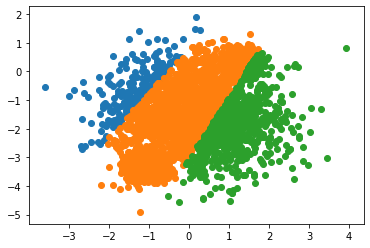

In [27]:
# getting data
train_data, val_data = load_2D()

K = 3
MU = Kmeans(train_data, K)

S = get_clusters(train_data, MU)

# below is pseudo-code, idk if it runs
for i in range(K):
    x = S[i][:,0]
    y = S[i][:,1]
    plt.scatter(x, y)  # plt should automatically color the custers differently
plt.show()

\newpage

# 2 Mixtures of Gaussians {-}

## 2.1 The Guassian Cluster Model {-}

In [10]:
# Distance function for GMM
def distanceFunc_GM(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    
    """
    NOT SURE IF THIS IS CORRECT
    
    I am fairly certain that what they want is something i wrote into the log_GaussPDF function.
    I have no idea why they even included this in the helper file for gmm, it should just be log_Gauss -Devansh
    """
    
    pair_dist = []
    for x in X:
        row = []
        for mu in MU:
            row.append( np.square(x - mu).sum() )
        pair_dist.append( row )
    
    # only difference is that I square root here
    
    # sorry bro, I think this is wrong -Devansh
    return np.sqrt(pair_dist)

def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    K, N, D = len(mu), len(X), len(X[0])

    pair_dist = []
    for x in X:
        row = []
        for k, mu_k in enumerate(mu):
            # Note that (x-mu).T @ sigma[k]*{dxd identity matrix} @ (x-mu) = 1/sigma[k] * ||x-mu||
            # since sigma[k] is a constant

            # Note that the determinant of a constant times an nxn Identity matrix is the constant raised to n
            # because determinant is linear in each column and the determinant of the identity matrix is 1
            prob = np.exp(-0.5 * np.square(x - mu_k).sum() / sigma[k]) / np.sqrt((2 * np.pi) ** K * sigma[k] ** D)
            row.append(np.log(prob))
        pair_dist.append(row)

    # So, the output here is an NxK matrix. The i,j entry represent the log probability of the the i-th example
    # belonging to cluster j.
    return np.array(pair_dist)

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # So this essentially just normalizes each row of the log_PDF so that each row is a valid probability distribution
    # idk how tensor stuff works, so I'm going to leave you with a breakdown of what this fcn needs to do Sandra
    
    # The input log_PDF is an NxK matrix. Each entry needs to have a term subtracted from it. the update is as follows
    # log_PDF[i][j] = log_PDF[i][j] - log_sumOfExponentialsOfAllEntriesInRowi
    
    # that's literally it
    # Fortunately, the helper function called reduce_logsumexp calculates exactly this.
    
    # reduce_logsumexp should take in the log_PDF matrix (in the form of a tf tensor) and it will output a tensor
    # of dimension Nx1. Please do some vector magic and subtract the i-th entry of this tensor from every
    # entry in the i-th row of log_PDF
    # Thanks!
    return log_PDF

In [11]:
train_data, val_data = load_2D()

N, D = train_data.shape
K = 3

MU = np.random.random_sample((K, D))
pair_dist = distanceFunc_Kmeans(train_data, MU)
print(pair_dist.shape)

(6667, 3)


## 2.2 Learning the MoG {-}

In [12]:
def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    # TODO
    """
    See above cell for 2.1
    """

def log_posterior(log_PDF):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # TODO
    """
    See above cell for 2.1
    """
    
def neg_log_likelihood_gmm(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_likelihood: scalar

    """
    Not sure if this can be vectorized if need for speed
    """
    neg_log_likelihood = 0
    for n, sample in enumerate(log_PDF):
        prob = 0
        for k, clusters in enumerate(sample):
            prob += np.exp(log_pi[k] + log_PDF[n][k])
        neg_log_likelihood -= np.log(prob)
    
    return neg_log_likelihood

# Hello Sandra <3
This section requires us to use tensorflow to use gradient descent to minimize the output of the neg_log_likelihood_gmm function. Can you please do that thanks very much.

Notes:

- The parameters we can change through gradient descent are the entries of matrix MU (NxK), vector sigma (Kx1), and vector pi (Kx1)
- each entry of the sigma vector have a constraint that  they must be non-negative (i.e. $\forall k, \sigma_k \in [0,\infty)$)
    - suggestion from the handout to deal with this: replace $sigma^2$ with exp($\phi$) in the math and the software where $\phi$ is an unconstrained parameter
- the entries of the pi vector must sum up to one (since it is a probability distribution) (i.e. $\sum_{k}\pi_k = 1$)
    - suggestion from the handout to deal with this: replace this constraint with an unconstrained parameter $\psi$ through softmax function $\pi_k = \frac{exp(\psi_k)}{\sum_{k'}exp(\psi_{k'})}. A log-softmax function is provided in the helper functions file

Rest of the assignment is just tensorflow make model and train

With love, Devansh